# YOLOv5 Inference

## Cloning the repository

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 0e5cfdbea756716d5bbdfe6f3b26b2731e2facc4
!pwd

Cloning into 'yolov5'...
remote: Enumerating objects: 8982, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 8982 (delta 4), reused 10 (delta 3), pack-reused 8963
Receiving objects: 100% (8982/8982), 9.41 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (6248/6248), done.
/content/yolov5
HEAD is now at 0e5cfdb Refactor models/export.py arguments (#3564)
/content/yolov5


# Installing repositories

In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch
  
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 636 kB 8.6 MB/s 
Setup complete. Using torch 1.9.0+cu102 CPU


# Downloading the dataest

In [3]:
# Export code snippet and paste here
%cd /content
!curl -L "https://app.roboflow.com/ds/q91Y8tjqmp?key=XdXSj52rf1" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1076      0 --:--:-- --:--:-- --:--:--  1075
100 41.2M  100 41.2M    0     0  16.8M      0  0:00:02  0:00:02 --:--:--  165M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/OC_paper_10page_19_GDOg08g_jpg.rf.e354ae0ba8ae7a0a5d2f967ef2cc9e1e.jpg  
 extracting: test/images/OC_paper_10page_22_3PkZj5o_jpg.rf.64b6d376b06de83cc850cdb01d9ee9c6.jpg  
 extracting: test/images/OC_paper_10page_52_1vwFCFL_jpg.rf.465125e91f26498a9570dad3a57dabfc.jpg  
 extracting: test/images/OC_paper_10page_57_sqn1Vg0_jpg.rf.de26c677afdf4d72edeabf8f7f8c52cd.jpg  
 extracting: test/images/OC_paper_10page_60_lry8YBM_jpg.rf.e9500b074524ca78911fb575dcc827d4.jpg  
 extracting: test/images/OC_paper_10page_

In [4]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [5]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [6]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Running Inference
Make sure you upload the weigts file and specify the path to it as the `weights` argument

In [8]:
%cd /content/yolov5/
!sudo rm -r runs/
from detect import detect

# run(weights='/content/drive/MyDrive/best.pt', source='/content/test/images', line_thickness=2, conf_thres=0.5, hide_labels=False, save_crop=True)
detect(weights='/content/v2_1000.pt', source='/content/test/images', line_thickness=2, conf_thres=0.5, hide_labels=False, save_crop=True)

/content/yolov5


YOLOv5 🚀 v5.0-173-g0e5cfdb torch 1.9.0+cu102 CPU

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPs


image 1/33 /content/test/images/OC_paper_10page_19_GDOg08g_jpg.rf.e354ae0ba8ae7a0a5d2f967ef2cc9e1e.jpg: 640x640 6 compound-structures, Done. (0.456s)
image 2/33 /content/test/images/OC_paper_10page_22_3PkZj5o_jpg.rf.64b6d376b06de83cc850cdb01d9ee9c6.jpg: 640x640 11 compound-structures, 5 reaction-arrows, Done. (0.313s)
image 3/33 /content/test/images/OC_paper_10page_52_1vwFCFL_jpg.rf.465125e91f26498a9570dad3a57dabfc.jpg: 640x640 4 compound-structures, Done. (0.306s)
image 4/33 /content/test/images/OC_paper_10page_57_sqn1Vg0_jpg.rf.de26c677afdf4d72edeabf8f7f8c52cd.jpg: 640x640 8 compound-structures, Done. (0.304s)
image 5/33 /content/test/images/OC_paper_10page_60_lry8YBM_jpg.rf.e9500b074524ca78911fb575dcc827d4.jpg: 640x640 12 compound-structures, Done. (0.312s)
image 6/33 /content/test/images/OC_paper_10page_82_HGZYakz_jpg.rf.804b7e8e3c73c3581c42d52fda630e81.jpg: 640x640 13 compound-structures, Done. (0.318s)
image 7/33 /content/test/images/OC_paper_10page_83_bDSItvF_jpg.rf.c58bd1332767

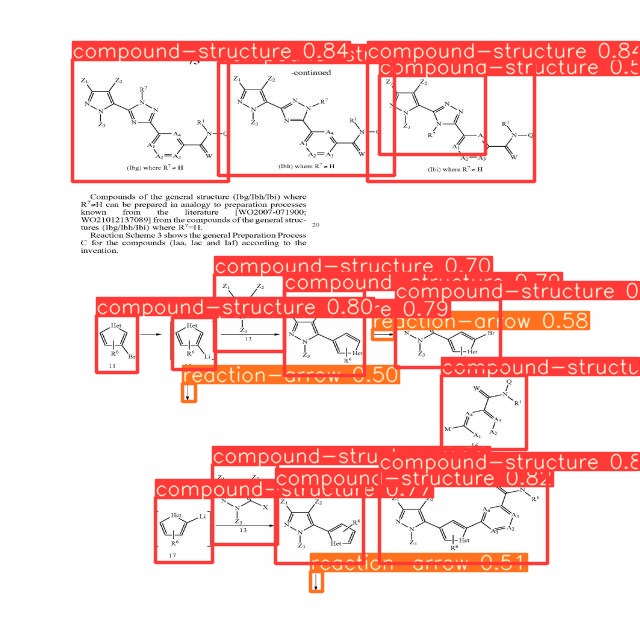

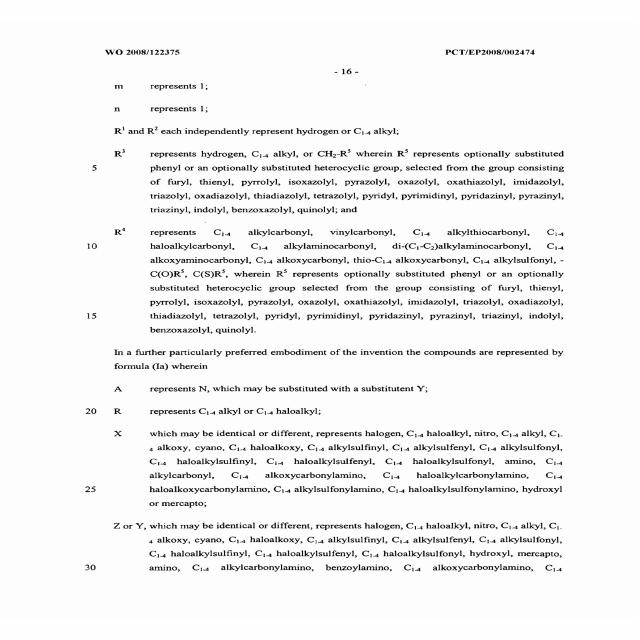

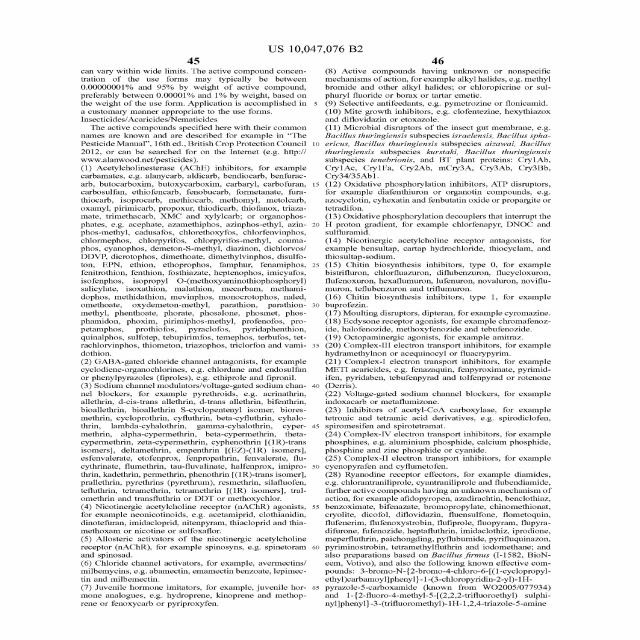

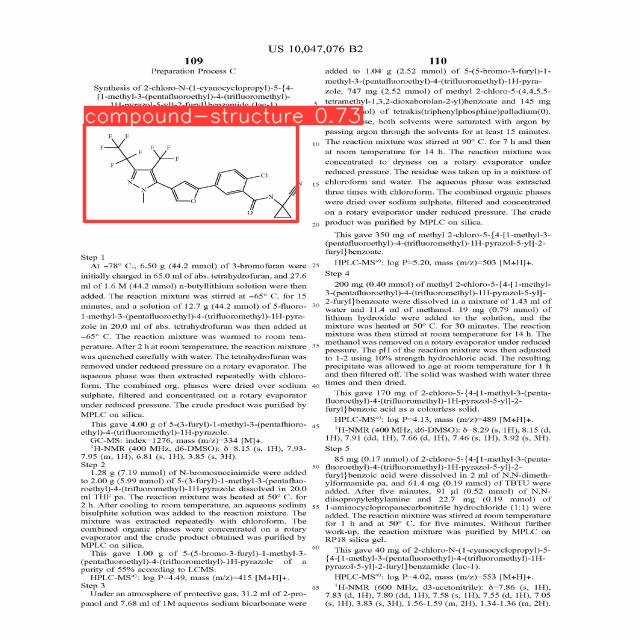

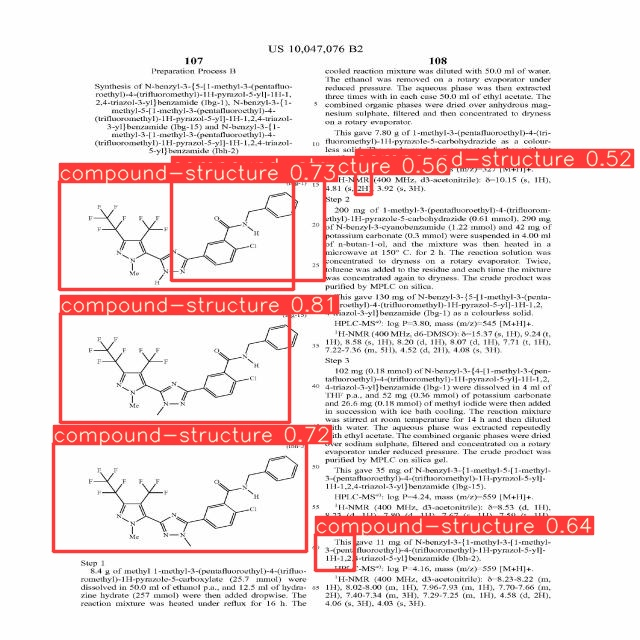

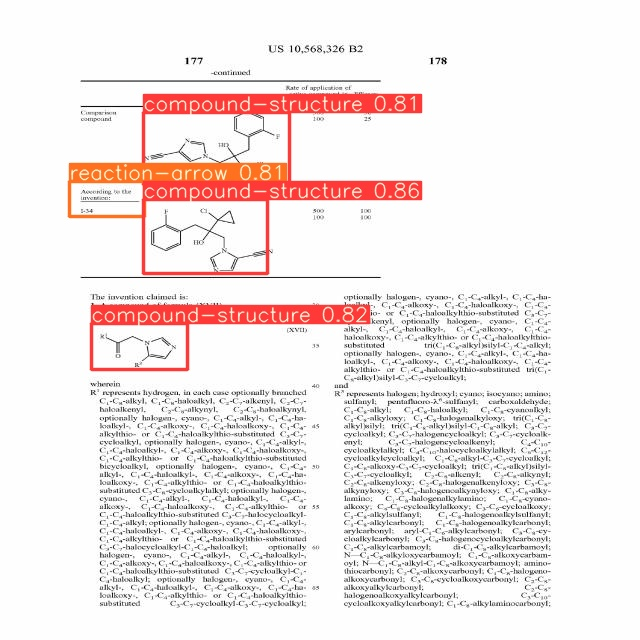

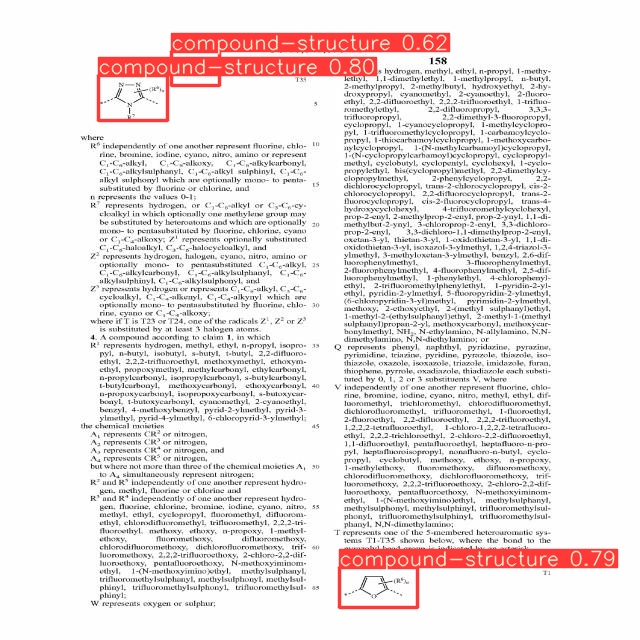

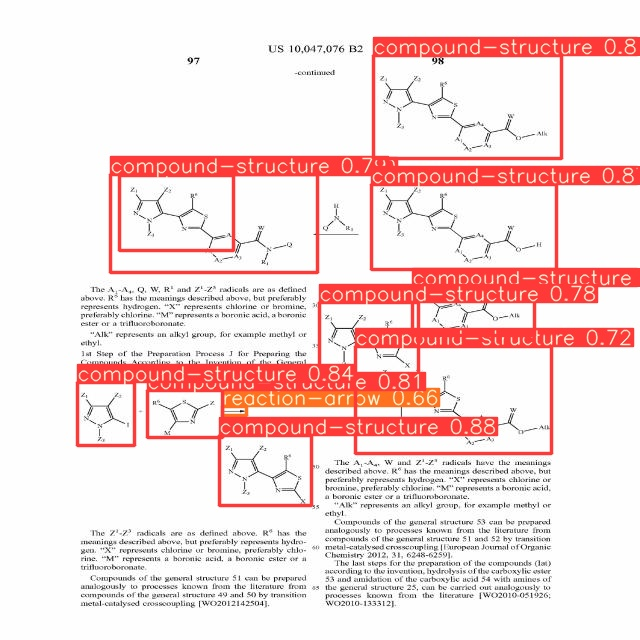

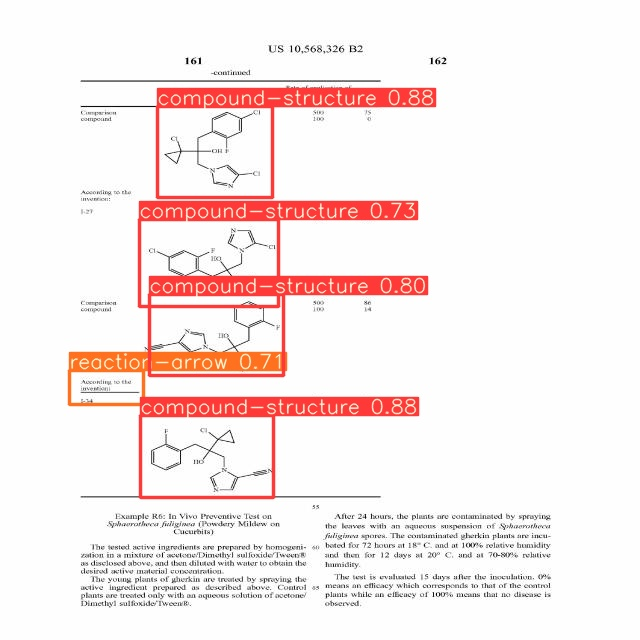

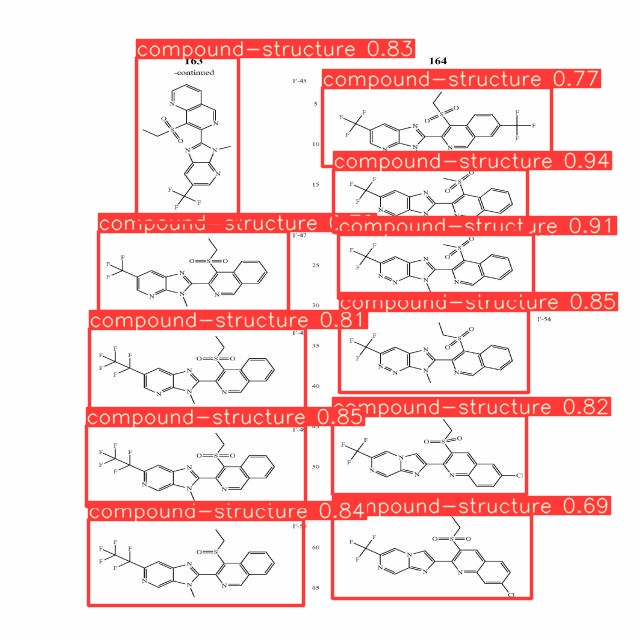

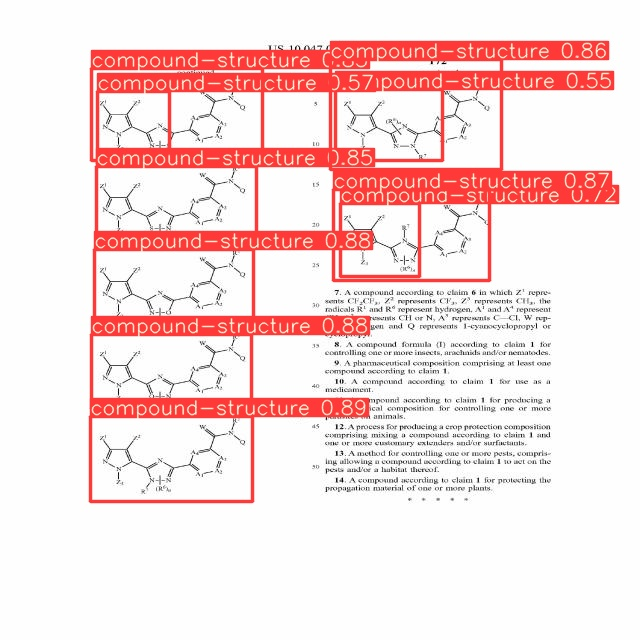

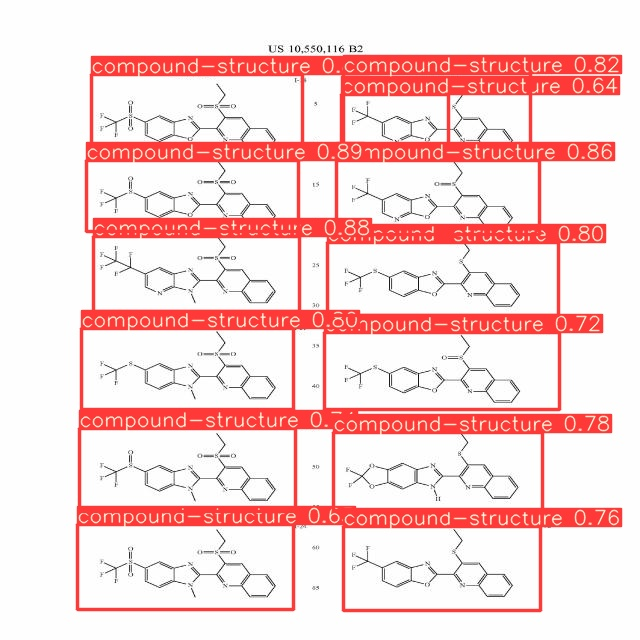

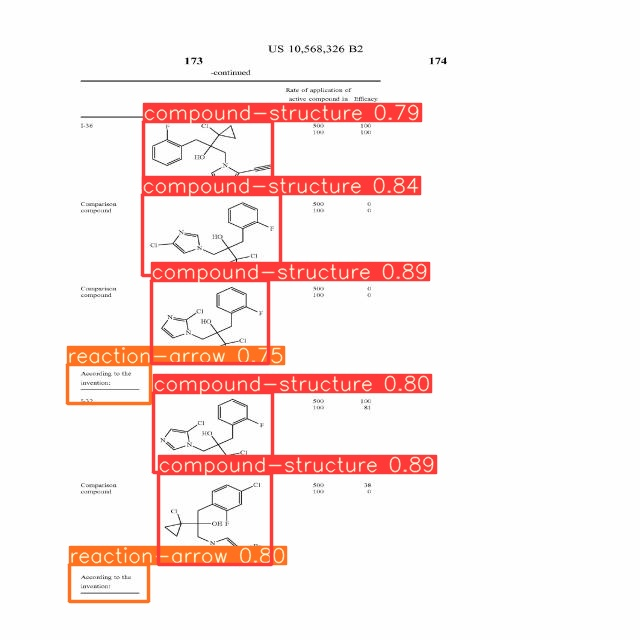

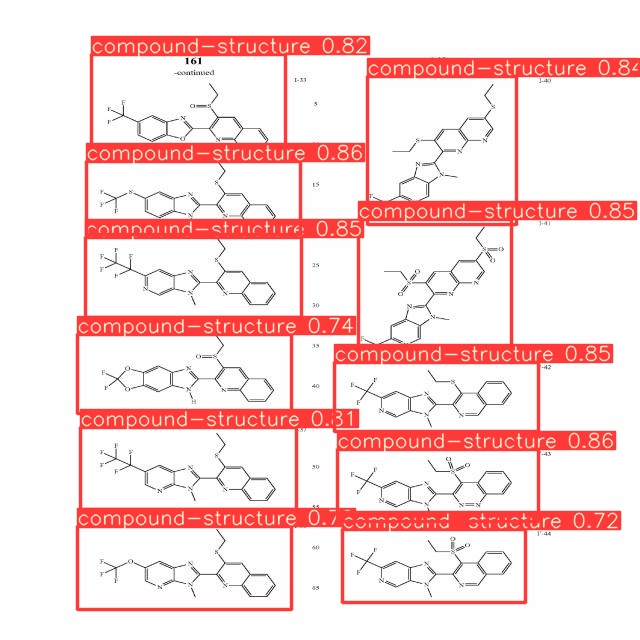

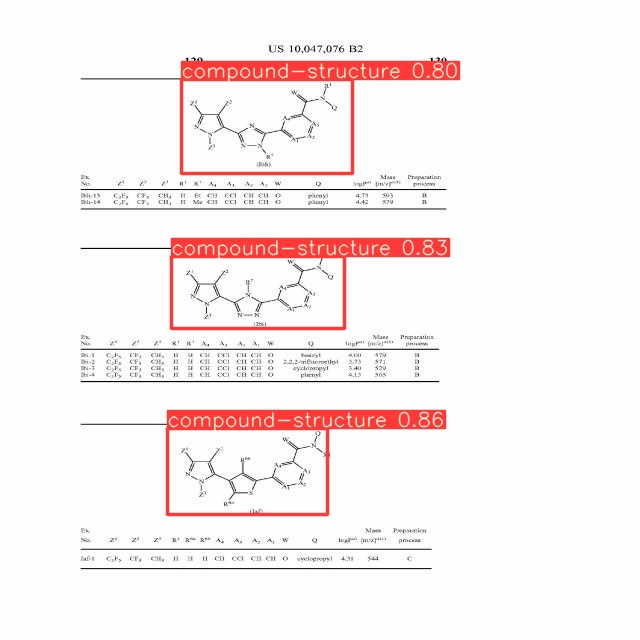

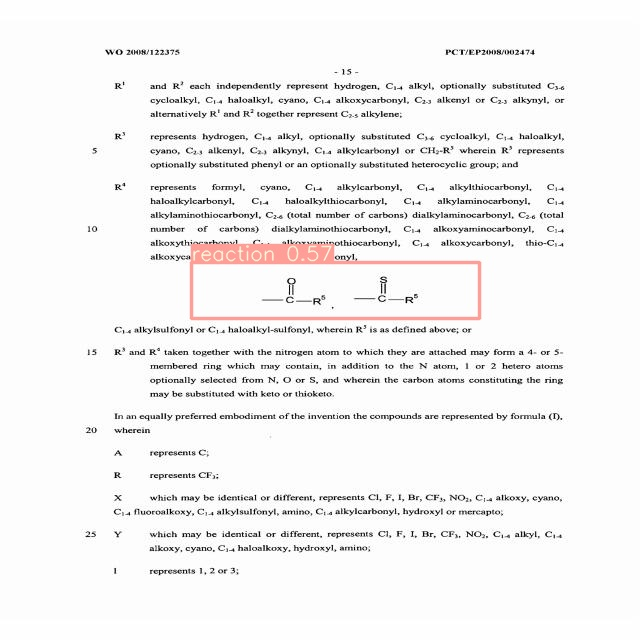

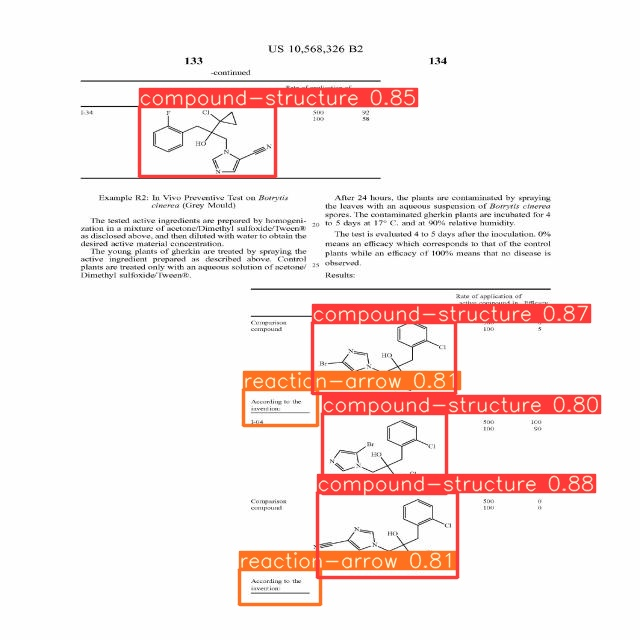

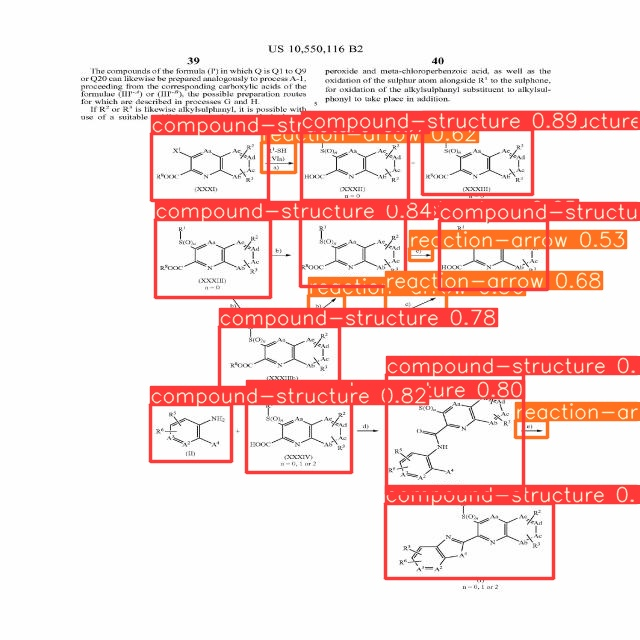

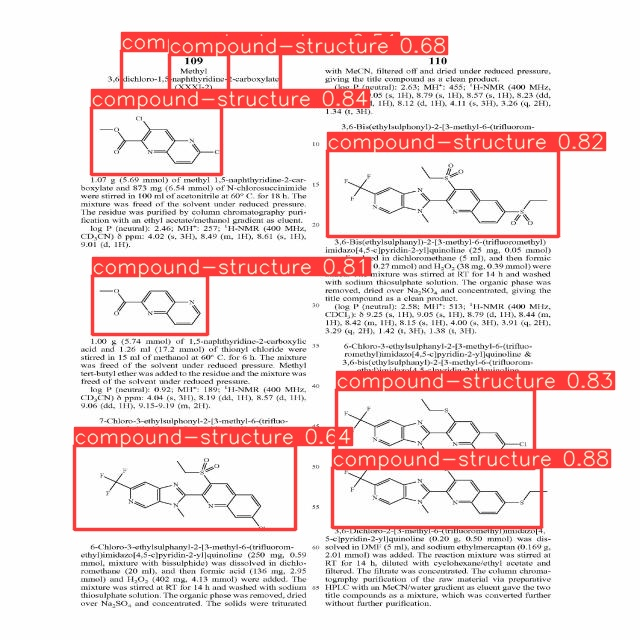

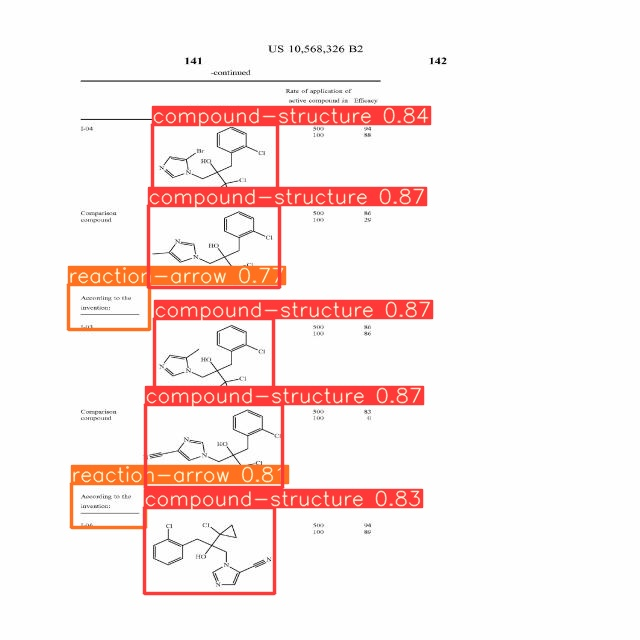

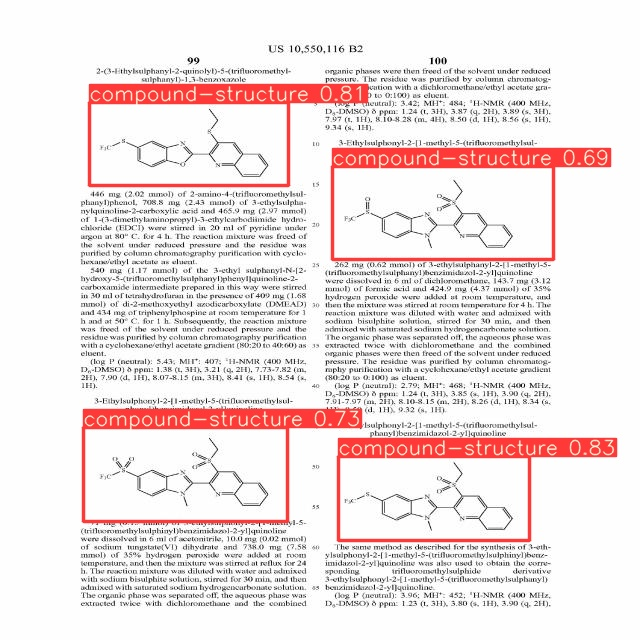

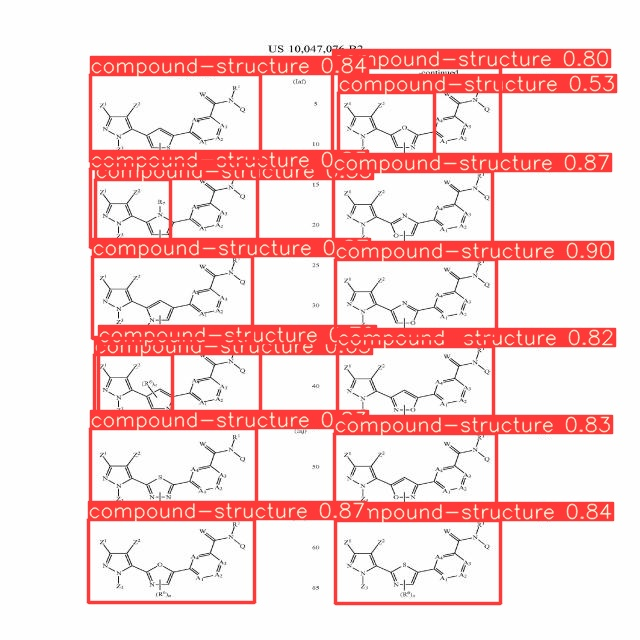

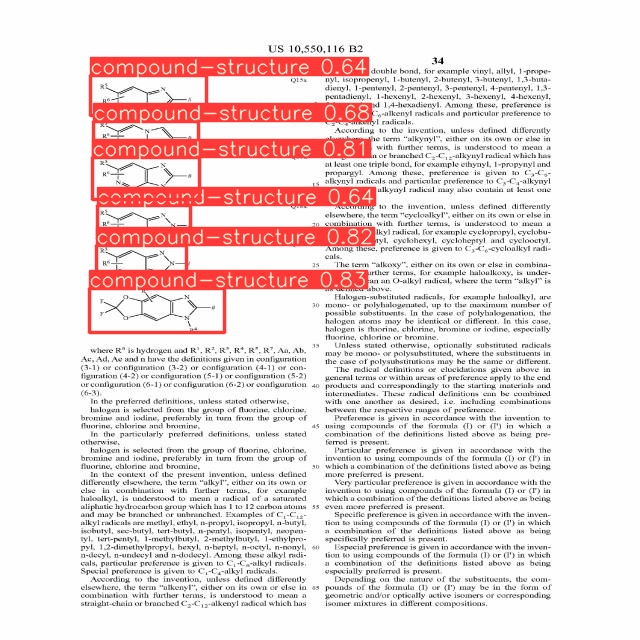

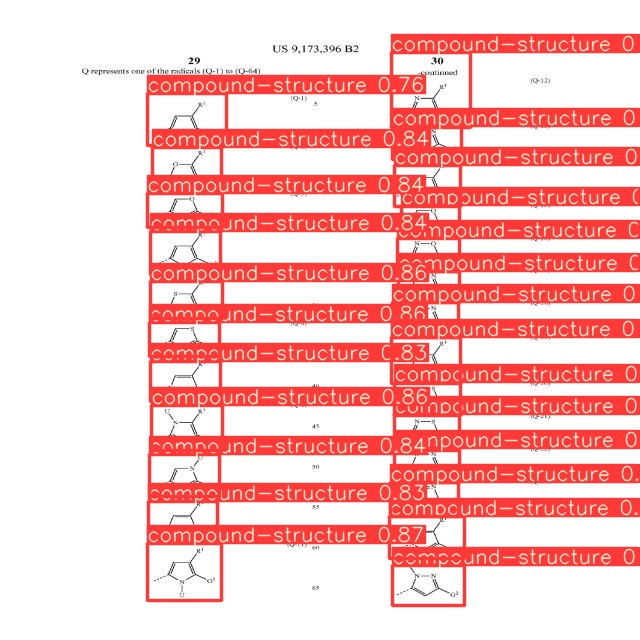

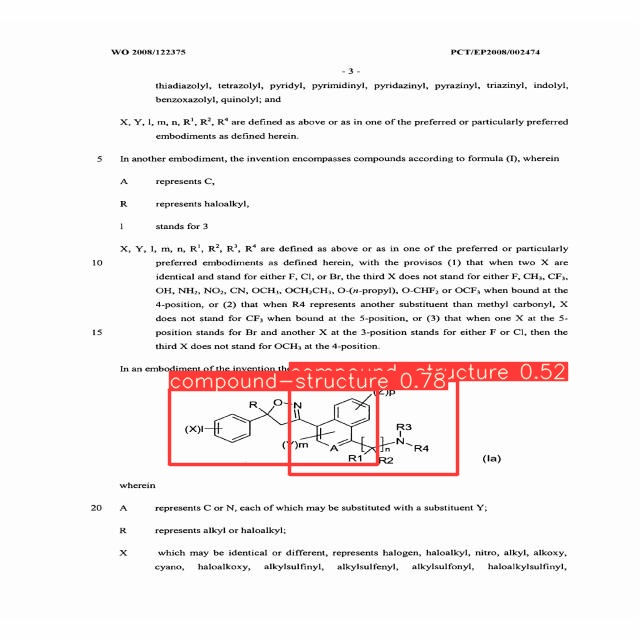

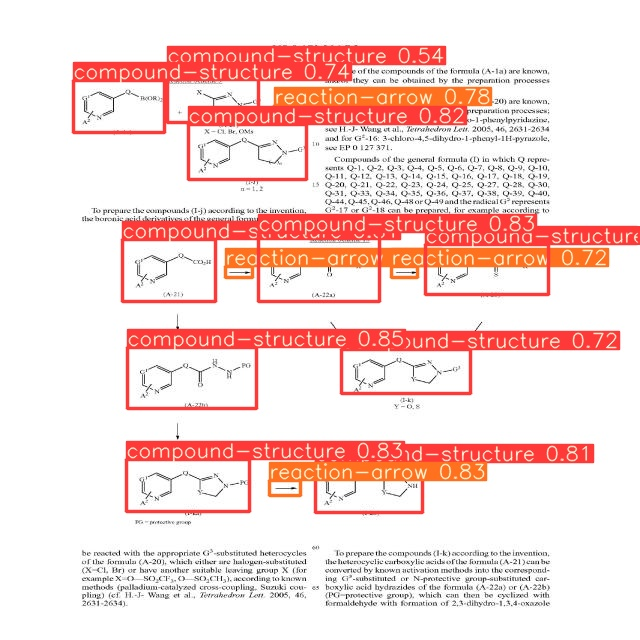

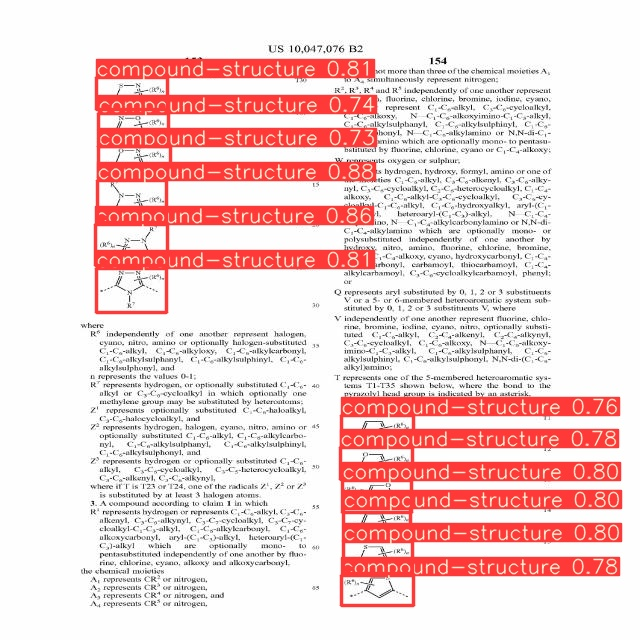

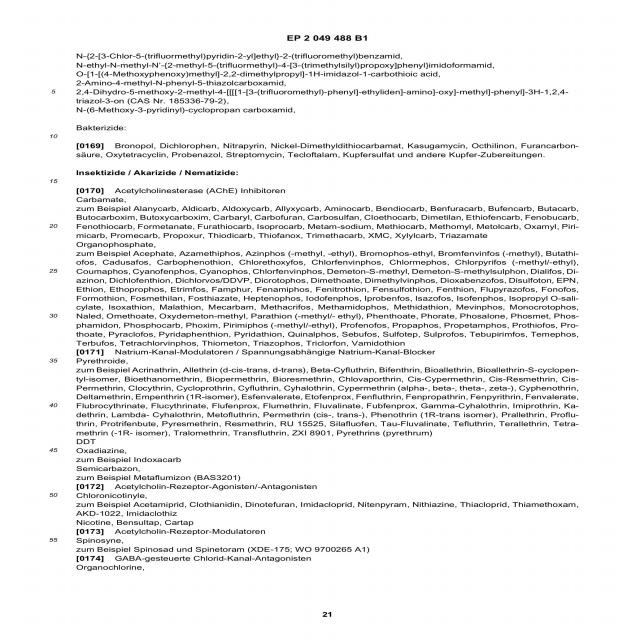

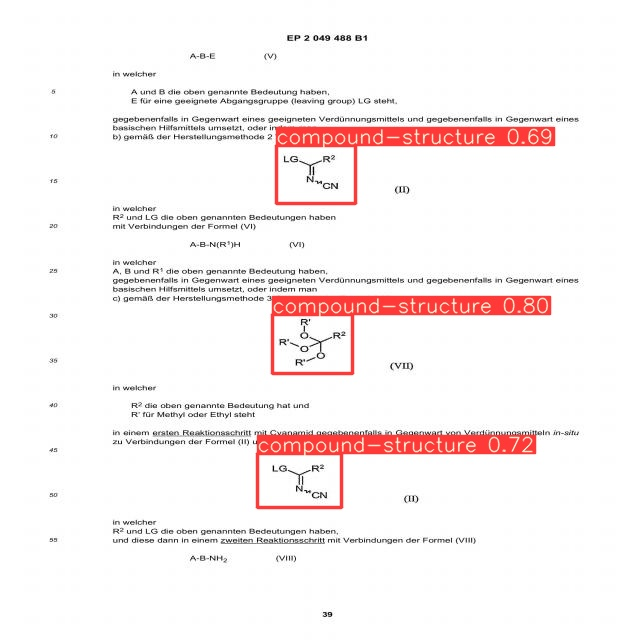

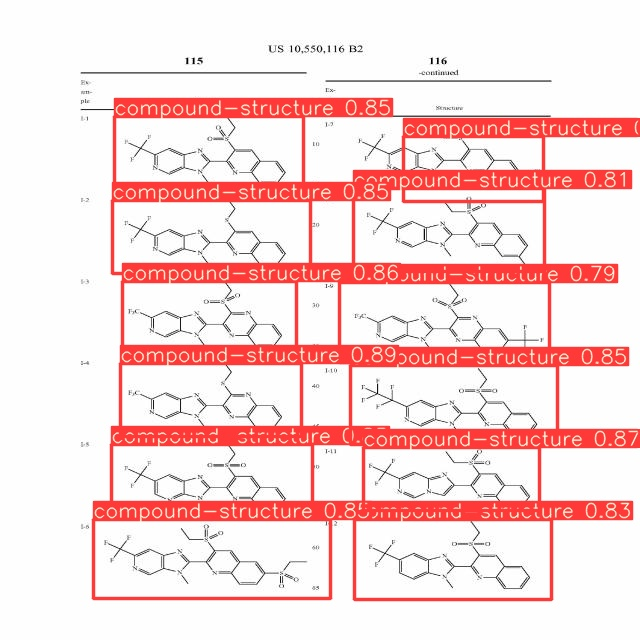

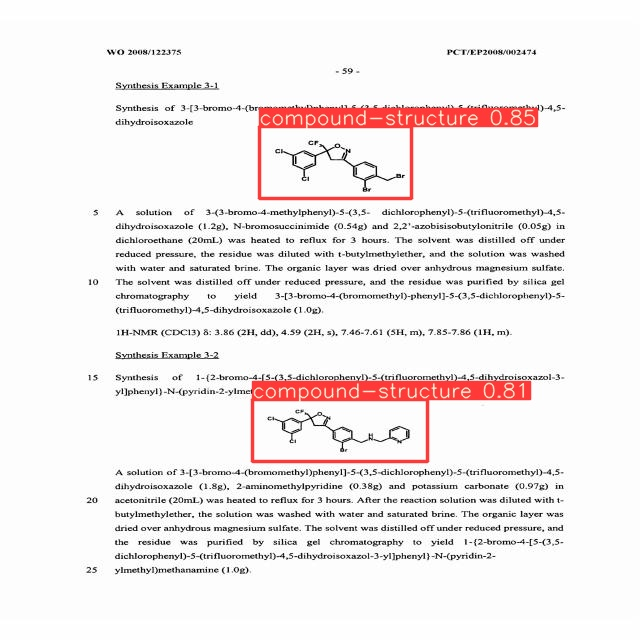

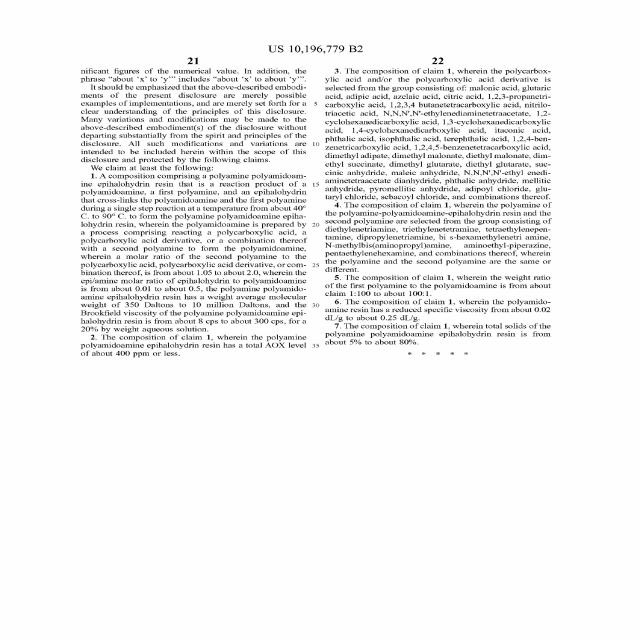

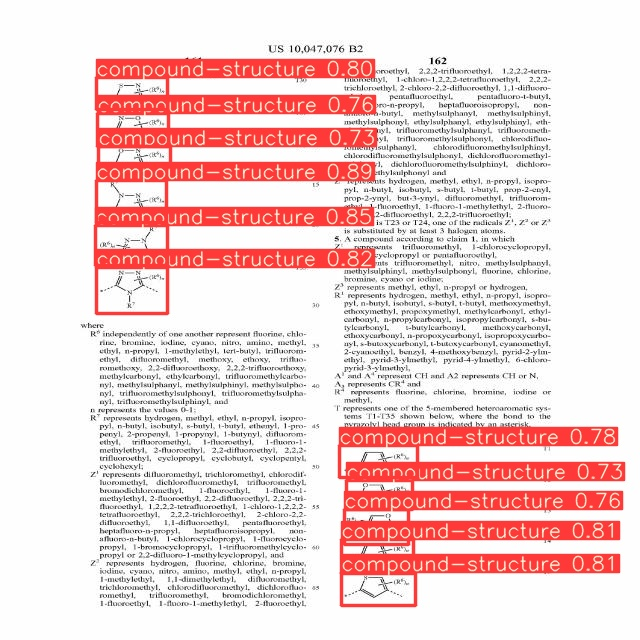

In [9]:
#display inference on ALL test images 
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")